In [5]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

## Load data

In [2]:
transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
            ])

batch_size = 4

#train data
trainset = datasets.CIFAR10(root= 'data', train= True, download=True, transform = transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, shuffle=True)


#test data
testset = datasets.CIFAR10(root= 'data', train=False, download= True, transform = transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size= batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
import matplotlib.pyplot as plt
import numpy as np


#function to show image
def show_image(img) :
    img = img /2 + 0.5 #unnormalize the image
    np_img = img.numpy()  #cannot plot torch tensors
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.show()
    

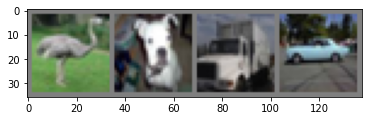

      bird        dog      truck        car


In [7]:
#get some random image
dataiter = iter(train_loader)
images, labels = next(dataiter)

#show images
show_image(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(batch_size)))

In [10]:
images[0].shape

torch.Size([3, 32, 32])

## Define the Network

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [31]:
# Define a Convulational Network

class ConvulationalNetwork(nn.Module) :
    
    def __init__(self) :
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels= 6, kernel_size= 5, stride=1)
        self.pool = nn.MaxPool2d(kernel_size= 2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        
    def forward(self, x) :
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) #Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [32]:
model = ConvulationalNetwork()
print(model)

ConvulationalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [33]:
total = 0
for param in model.parameters() :
    print(torch.numel(param))
    total += torch.numel(param)
    
print(f'Total Parameters {total}')

450
6
2400
16
48000
120
10080
84
840
10
Total Parameters 62006


In [34]:
#define the loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.001, momentum= 0.9)

In [35]:
model = model.to(device)

## Train the Network

In [36]:
def training_loop(dataloader, model, criterion, optimizer) :
    
    size = len(dataloader.dataset) #total number of rows
    model.train()
    for batch, (X,y) in enumerate(dataloader) :
        X, y = X.to(device), y.to(device)
        
        prediction = model(X)
        loss = criterion(prediction, y)
        
        #calculating gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print statistics
        if batch % 100 == 0 :
            loss, current = loss.item(), batch * len(X)
            print(f"Training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
        

In [37]:
def testing_loop(dataloader, model, criterion) :
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad() :
        for batch, (X,y) in enumerate(dataloader) :
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    #print statistics
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        

In [38]:
import time
start_time = time.time()
epochs = 3

for epoch in range(epochs) :
    print(f'Epoch {epoch+1} \n ----------------------\n')
    training_loop(train_loader, model, criterion, optimizer )
    testing_loop(test_loader, model, criterion)

Epoch 1 
 ----------------------

Training loss: 2.304145  [    0/50000]
Training loss: 2.294745  [  400/50000]
Training loss: 2.285513  [  800/50000]
Training loss: 2.289831  [ 1200/50000]
Training loss: 2.271322  [ 1600/50000]
Training loss: 2.333853  [ 2000/50000]
Training loss: 2.262995  [ 2400/50000]
Training loss: 2.275679  [ 2800/50000]
Training loss: 2.309257  [ 3200/50000]
Training loss: 2.431093  [ 3600/50000]
Training loss: 2.278236  [ 4000/50000]
Training loss: 2.064223  [ 4400/50000]
Training loss: 2.320220  [ 4800/50000]
Training loss: 2.248541  [ 5200/50000]
Training loss: 2.099114  [ 5600/50000]
Training loss: 2.228635  [ 6000/50000]
Training loss: 2.057397  [ 6400/50000]
Training loss: 2.418463  [ 6800/50000]
Training loss: 1.995291  [ 7200/50000]
Training loss: 1.863706  [ 7600/50000]
Training loss: 2.062203  [ 8000/50000]
Training loss: 2.285741  [ 8400/50000]
Training loss: 2.413211  [ 8800/50000]
Training loss: 1.892609  [ 9200/50000]
Training loss: 1.419099  [ 960

Training loss: 2.015714  [32800/50000]
Training loss: 2.135219  [33200/50000]
Training loss: 1.162456  [33600/50000]
Training loss: 0.228608  [34000/50000]
Training loss: 0.549794  [34400/50000]
Training loss: 1.665113  [34800/50000]
Training loss: 1.212996  [35200/50000]
Training loss: 0.932245  [35600/50000]
Training loss: 1.054448  [36000/50000]
Training loss: 1.264086  [36400/50000]
Training loss: 1.281251  [36800/50000]
Training loss: 1.071819  [37200/50000]
Training loss: 0.768213  [37600/50000]
Training loss: 1.260580  [38000/50000]
Training loss: 1.473519  [38400/50000]
Training loss: 2.343426  [38800/50000]
Training loss: 0.302313  [39200/50000]
Training loss: 0.971420  [39600/50000]
Training loss: 1.747787  [40000/50000]
Training loss: 0.779521  [40400/50000]
Training loss: 1.006080  [40800/50000]
Training loss: 1.543344  [41200/50000]
Training loss: 2.408731  [41600/50000]
Training loss: 1.096691  [42000/50000]
Training loss: 0.997037  [42400/50000]
Training loss: 1.227584  